# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Prediction Modeling 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q6"> 5. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
import warnings
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
%matplotlib inline

In [3]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [4]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2281014 entries, 0 to 2281013
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20867
Address                             12
Zip Code                         13943
Council District                 47071
APD Sector                        8850
APD District                      9320
PRA                              10563
Census Tract                   1485251
Clearance Status                603999
Clearance Date                  334792
UCR Category                   1504740
Category Description           1504740
X-coordinate                      9986
Y-coordinate                      9986
Latitude                         38484
Longitude                

## II. Data Scrubbing

There are several columns of data we don't need. We'll drop those and also scrub the Columns were keeping for analysis. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The 'clearance status' column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed it to boolean type:  Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am unsure how best to handle this so I am open to suggestions or advice. I also converted the 'family violence' column to boolean type.  

In [5]:
# Data-scrubbing script

def clean_data(df):
    drop_col = [
        "Occurred Time",
        "Occurred Date",
        "Family Violence",
        "Clearance Status",
        "Report Date",
        "Report Time",
        "Clearance Date",
        "Census Tract",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    clean_col = ["Report Date Time", "Occurred Date Time"]
    df.drop(drop_col, axis=1, inplace=True)
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    date_col = ["occurred_date_time", "report_date_time"]
    cat_col  = ["highest_offense_description", "location_type", "apd_sector"]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col]  = df[cat_col].astype("category")
    df["year"]  = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.month
    df["week"]  = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.week
    df["day"]   = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.day
    df["hour"]  = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.hour
    df.set_index(["occurred_date_time"], inplace=True)
    df.sort_index(inplace=True)
    return df

df = clean_data(df)

In [6]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                    0
highest_offense_description        0
highest_offense_code               0
report_date_time                   0
location_type                  20783
address                           12
zip_code                       13930
council_district               47058
apd_sector                      8848
apd_district                    9318
pra                            10558
latitude                       38478
longitude                      38478
year                               0
month                              0
week                               0
day                                0
hour                               0
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
report_date_time               datetime64[ns]
location_type                        category
address                                object
zip_code                              float64
council_district                      float64
apd_sector                           category
apd_district                           object
pra                                    object
latitude                              float64
longitude                             float64
year                                    int64
month                                   int64
week                                    int64
day                                     int64
hour                                    int64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2003-01-01,20115007026,IDENTITY THEFT,4022,2011-02-08 15:14:00,RESIDENCE / HOME,8220 W SH 71,78735.0,8.0,DA,6,61,30.246747,-97.887325,2003,1,1,1,0
2003-01-01,20125033273,AGG SEXUAL ASSAULT CHILD/OBJEC,1712,2012-07-18 12:00:00,RESIDENCE / HOME,1100 BLOCK HARVEY ST,78702.0,1.0,CH,2,415,NaN,NaN,2003,1,1,1,0
2003-01-01,20055067732,IDENTITY THEFT,4022,2005-02-14 17:30:00,COMMERCIAL / OFFICE BUILDING,715 E 8TH ST,78701.0,9.0,GE,2,382,30.267553,-97.734674,2003,1,1,1,0
2003-01-01,20105018815,IDENTITY THEFT,4022,2010-04-14 14:59:00,RESIDENCE / HOME,1088 PARK PLZ,78753.0,4.0,ED,3,251,30.348871,-97.685233,2003,1,1,1,0
2003-01-01,20125057357,IDENTITY THEFT,4022,2012-12-27 16:17:00,RESIDENCE / HOME,1738 RUTLAND DR,78758.0,4.0,ED,2,219,30.376093,-97.710471,2003,1,1,1,0


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2020-10-31 16:00:00,20205044061,BURGLARY OF VEHICLE,601,2020-10-31 20:09:00,RESIDENCE / HOME,8524 BURNET RD,78757.0,7.0,BA,6,233,30.366942,-97.728403,2020,10,44,31,16
2020-10-31 16:00:00,20205044053,CHILD CUSTODY INTERFERE,2001,2020-10-31 17:33:00,RESIDENCE / HOME,6725 CIRCLE S RD,78745.0,2.0,FR,3,528,30.190841,-97.777863,2020,10,44,31,16
2020-10-31 17:14:00,20205044051,THEFT,600,2020-10-31 17:14:00,RESIDENCE / HOME,8600 N FM 620 RD,78726.0,6.0,AD,8,576,30.425189,-97.845123,2020,10,44,31,17
2020-10-31 17:30:00,20205044064,BURGLARY NON RESIDENCE,502,2020-10-31 20:58:00,COMMERCIAL / OFFICE BUILDING,6633 E US 290 HWY EB,78723.0,1.0,ID,5,292,30.321190,-97.695712,2020,10,44,31,17
2020-10-31 19:10:00,20205044062,THEFT,600,2020-10-31 20:42:00,DEPARTMENT / DISCOUNT STORE,9600 S IH 35 NB,78744.0,5.0,FR,7,543,30.158684,-97.789851,2020,10,44,31,19


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

### Overall crime rates over time 

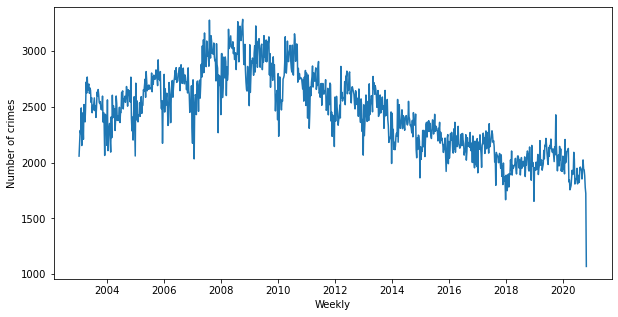

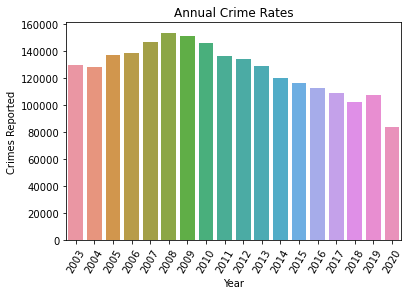

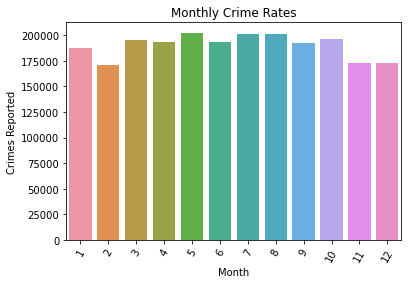

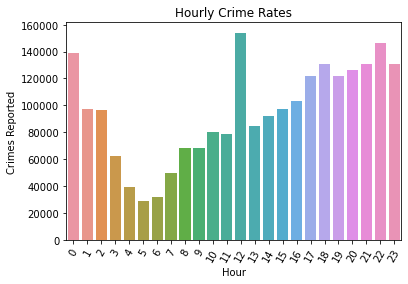

In [7]:
# plotting trend on a weekly basis

plt.figure(figsize=(10, 5))
plt.plot(df.resample("W").size())
plt.xlabel("Weekly")
plt.ylabel("Number of crimes")
plt.show()

figsize = (20, 10)

# Creating and visualizing a data frame for the overall yearly crime rate since 2003

crimes_per_year = df["year"].value_counts().sort_index()

g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(xlabel="Year", ylabel="Crimes Reported", title="Annual Crime Rates")
plt.show()

# Creating and visualizing a data frame for the overall yearly crime rate since 2003

crimes_per_month = df["month"].value_counts().sort_index()

d = sns.barplot(x=crimes_per_month.index, y=crimes_per_month.values)
d.set_xticklabels(d.get_xticklabels(), rotation=60)
d.set(xlabel="Month", ylabel="Crimes Reported", title="Monthly Crime Rates")
plt.show()

# Overall hourly crime rates as well

crimes_per_hour = df["hour"].value_counts().sort_index()

e = sns.barplot(x=crimes_per_hour.index, y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), rotation=60)
e.set(xlabel="Hour", ylabel="Crimes Reported", title="Hourly Crime Rates")
plt.show()

### Top 50 crime types 

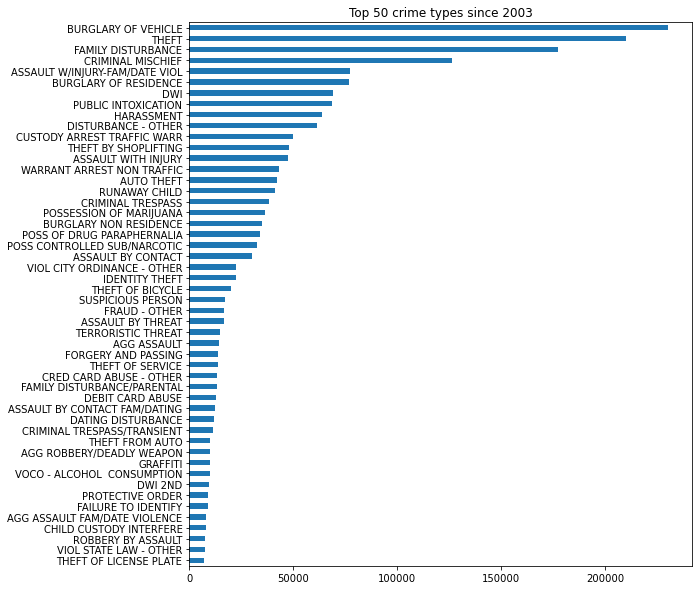

In [8]:
df.highest_offense_description.value_counts().head(50).sort_values().plot.barh(figsize=(9,
        10), title='Top 50 crime types since 2003')

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    205131
78753.0    177167
78701.0    167407
78758.0    157547
78704.0    153337
78745.0    149536
78702.0    135970
78744.0    125203
78723.0    117324
78752.0     83806
78748.0     67385
78759.0     65637
78751.0     63569
78757.0     57258
78705.0     56540
78721.0     47347
78749.0     40087
78724.0     37349
78727.0     35506
78703.0     34900
78731.0     28363
78746.0     27930
78729.0     25417
78750.0     23419
78754.0     22503
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090489
78753.0    0.078153
78701.0    0.073848
78758.0    0.069498
78704.0    0.067641
78745.0    0.065964
78702.0    0.059980
78744.0    0.055230
78723.0    0.051755
78752.0    0.036969
78748.0    0.029725
78759.0    0.028954
78751.0    0.028042
78757.0    0.025258
78705.0    0.024941
78721.0    0.020886
78749.0    0.017683
78724.0    0.016476
78727.0    0.015663
78703.0    0.015395
78731.0    0.012512
78746.0    0.012321
78729.0    0.011212
78750.0    0.010331
78754.0    0.009927
Name: zip_code, dtype: float64

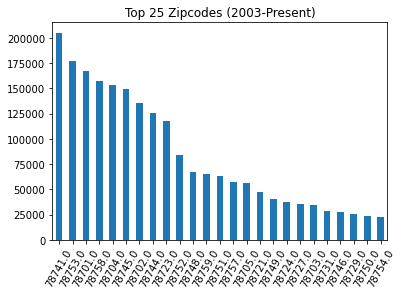

In [9]:
# Create and show dataframe for crime rates by zipcode and then as percentages

zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print("----------------------------------")
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime

df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 Zipcodes (2003-Present)"
)
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.14%. This is a significant 1.29 percentage points higher than the number 2 area 78753 which hosts 7.85% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             17011
BURGLARY OF VEHICLE               15853
FAMILY DISTURBANCE                14456
CRIMINAL MISCHIEF                  9335
THEFT BY SHOPLIFTING               7569
ASSAULT W/INJURY-FAM/DATE VIOL     7076
BURGLARY OF RESIDENCE              6027
DWI                                4923
DISTURBANCE - OTHER                4715
CUSTODY ARREST TRAFFIC WARR        4335
HARASSMENT                         4191
AUTO THEFT                         4121
POSS OF DRUG PARAPHERNALIA         3716
PUBLIC INTOXICATION                3357
ASSAULT WITH INJURY                3267
CRIMINAL TRESPASS                  3115
POSS CONTROLLED SUB/NARCOTIC       2954
RUNAWAY CHILD                      2909
WARRANT ARREST NON TRAFFIC         2787
POSSESSION OF MARIJUANA            2688
BURGLARY NON RESIDENCE             2463
VIOL CITY ORDINANCE - OTHER        1865
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096017
BURGLARY OF VEHICLE               0.089481
FAMILY DISTURBANCE                0.081595
CRIMINAL MISCHIEF                 0.052690
THEFT BY SHOPLIFTING              0.042722
ASSAULT W/INJURY-FAM/DATE VIOL    0.039940
BURGLARY OF RESIDENCE             0.034019
DWI                               0.027787
DISTURBANCE - OTHER               0.026613
CUSTODY ARREST TRAFFIC WARR       0.024468
HARASSMENT                        0.023656
AUTO THEFT                        0.023261
POSS OF DRUG PARAPHERNALIA        0.020975
PUBLIC INTOXICATION               0.018948
ASSAULT WITH INJURY               0.018440
CRIMINAL TRESPASS                 0.017582
POSS CONTROLLED SUB/NARCOTIC      0.016674
RUNAWAY CHILD                     0.016420
WARRANT ARREST NON TRAFFIC        0.015731
POSSESSION OF MARIJUANA           0.015172
BURGLARY NON RESIDENCE            0.013902
VIOL CITY ORDINANCE - OTHER       0.010527
Name: highest_offense_description, dtype: float64

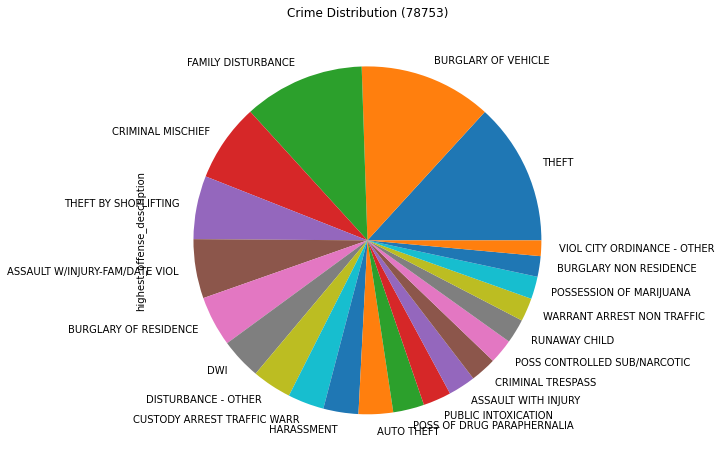

In [10]:
# Examining crime in the 78753 area

df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode

df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages

display(df_53_off)
print("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20125
BURGLARY OF VEHICLE               19717
THEFT                             15479
CRIMINAL MISCHIEF                 10951
ASSAULT W/INJURY-FAM/DATE VIOL     9574
BURGLARY OF RESIDENCE              8837
PUBLIC INTOXICATION                6366
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5622
HARASSMENT                         5450
DISTURBANCE - OTHER                5121
AUTO THEFT                         4544
ASSAULT WITH INJURY                4505
CRIMINAL TRESPASS                  3873
POSS CONTROLLED SUB/NARCOTIC       3829
POSSESSION OF MARIJUANA            3786
THEFT BY SHOPLIFTING               3565
POSS OF DRUG PARAPHERNALIA         3522
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2778
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098108
BURGLARY OF VEHICLE               0.096119
THEFT                             0.075459
CRIMINAL MISCHIEF                 0.053385
ASSAULT W/INJURY-FAM/DATE VIOL    0.046673
BURGLARY OF RESIDENCE             0.043080
PUBLIC INTOXICATION               0.031034
CUSTODY ARREST TRAFFIC WARR       0.029303
DWI                               0.027407
HARASSMENT                        0.026568
DISTURBANCE - OTHER               0.024965
AUTO THEFT                        0.022152
ASSAULT WITH INJURY               0.021962
CRIMINAL TRESPASS                 0.018881
POSS CONTROLLED SUB/NARCOTIC      0.018666
POSSESSION OF MARIJUANA           0.018456
THEFT BY SHOPLIFTING              0.017379
POSS OF DRUG PARAPHERNALIA        0.017170
WARRANT ARREST NON TRAFFIC        0.016809
RUNAWAY CHILD                     0.013543
VIOL CITY ORDINANCE - OTHER       0.010700
Name: highest_offense_description, dtype: float64

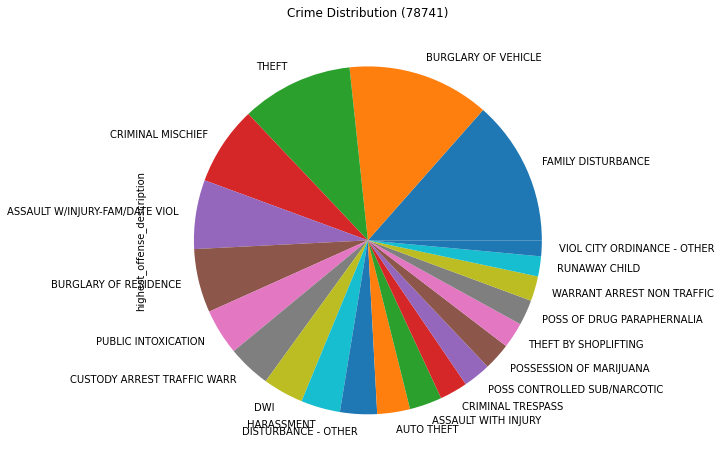

In [11]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)

df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode

df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages

display(df_41_off)
print ('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8, 8), title='Crime Distribution (78741)')

### D. Question 4. How is crime distributed in 78745?

FAMILY DISTURBANCE                14762
BURGLARY OF VEHICLE               14710
THEFT                             13449
CRIMINAL MISCHIEF                  8429
BURGLARY OF RESIDENCE              5850
ASSAULT W/INJURY-FAM/DATE VIOL     5707
HARASSMENT                         5100
DISTURBANCE - OTHER                4476
DWI                                4390
PUBLIC INTOXICATION                3987
CUSTODY ARREST TRAFFIC WARR        3244
BURGLARY NON RESIDENCE             2903
AUTO THEFT                         2803
ASSAULT WITH INJURY                2636
RUNAWAY CHILD                      2586
POSSESSION OF MARIJUANA            2584
WARRANT ARREST NON TRAFFIC         2107
POSS CONTROLLED SUB/NARCOTIC       2007
THEFT BY SHOPLIFTING               1955
CRIMINAL TRESPASS                  1933
IDENTITY THEFT                     1545
POSS OF DRUG PARAPHERNALIA         1511
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098719
BURGLARY OF VEHICLE               0.098371
THEFT                             0.089938
CRIMINAL MISCHIEF                 0.056368
BURGLARY OF RESIDENCE             0.039121
ASSAULT W/INJURY-FAM/DATE VIOL    0.038165
HARASSMENT                        0.034105
DISTURBANCE - OTHER               0.029933
DWI                               0.029357
PUBLIC INTOXICATION               0.026662
CUSTODY ARREST TRAFFIC WARR       0.021694
BURGLARY NON RESIDENCE            0.019413
AUTO THEFT                        0.018745
ASSAULT WITH INJURY               0.017628
RUNAWAY CHILD                     0.017293
POSSESSION OF MARIJUANA           0.017280
WARRANT ARREST NON TRAFFIC        0.014090
POSS CONTROLLED SUB/NARCOTIC      0.013422
THEFT BY SHOPLIFTING              0.013074
CRIMINAL TRESPASS                 0.012927
IDENTITY THEFT                    0.010332
POSS OF DRUG PARAPHERNALIA        0.010105
Name: highest_offense_description, dtype: float64

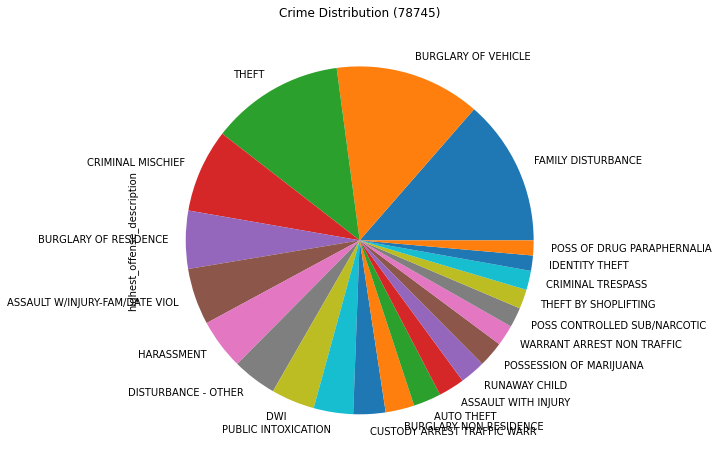

In [12]:
# Examining crime in the 78745 area

df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode

df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages

display(df_45_off)
print ('----------------------------------')
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))

df_45_off.plot.pie(figsize=(8, 8), title='Crime Distribution (78745)')

<a id='q4'></a>
### E. Question 5. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

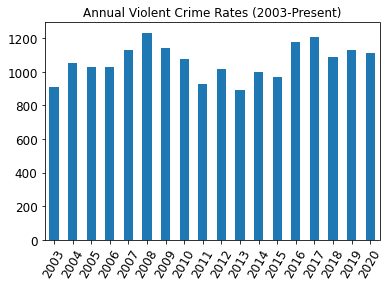

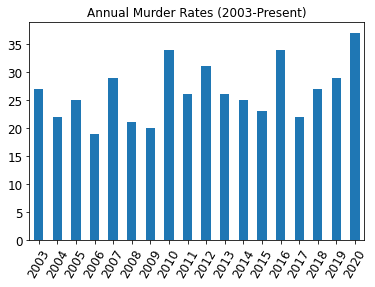

78741.0    0.114948
78701.0    0.097999
78753.0    0.092719
78758.0    0.083056
78702.0    0.074608
78723.0    0.066899
78745.0    0.059560
78744.0    0.054068
78704.0    0.050795
78752.0    0.046359
78721.0    0.031417
78724.0    0.027721
78705.0    0.025609
78757.0    0.019536
78748.0    0.018639
78751.0    0.017266
78759.0    0.012989
78749.0    0.008712
78617.0    0.008448
78722.0    0.008290
78754.0    0.008079
78727.0    0.007762
78729.0    0.007603
78750.0    0.005597
78731.0    0.005491
Name: zip_code, dtype: float64

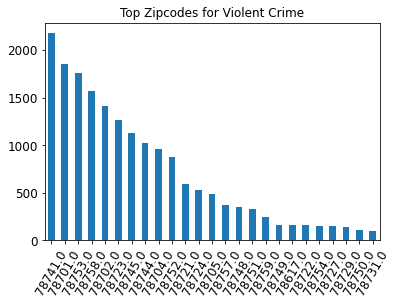

78753.0    0.111345
78741.0    0.107143
78723.0    0.094538
78758.0    0.092437
78744.0    0.069328
78702.0    0.058824
78745.0    0.058824
78752.0    0.056723
78701.0    0.039916
78704.0    0.037815
78721.0    0.033613
78724.0    0.029412
78749.0    0.023109
78751.0    0.016807
78705.0    0.016807
78757.0    0.016807
78727.0    0.014706
78748.0    0.014706
78759.0    0.014706
78754.0    0.012605
78617.0    0.012605
78731.0    0.010504
78750.0    0.008403
78747.0    0.008403
78735.0    0.006303
Name: zip_code, dtype: float64

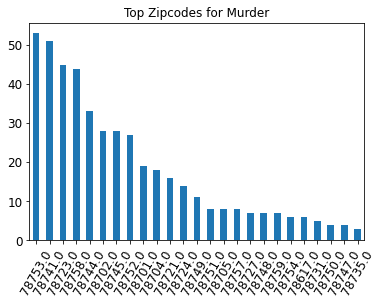

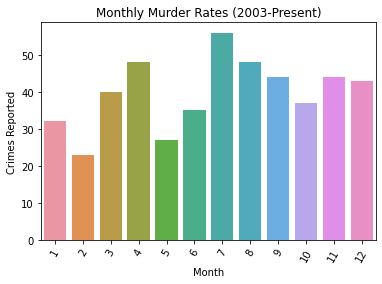

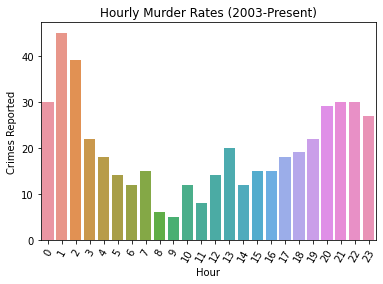

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610.0,1,0,0,0
78613.0,14,0,1,6
78617.0,118,0,6,36
78621.0,1,0,0,0
78634.0,1,0,0,0
78652.0,2,0,0,0
78653.0,10,0,1,1
78660.0,66,0,2,17
78664.0,3,0,0,0


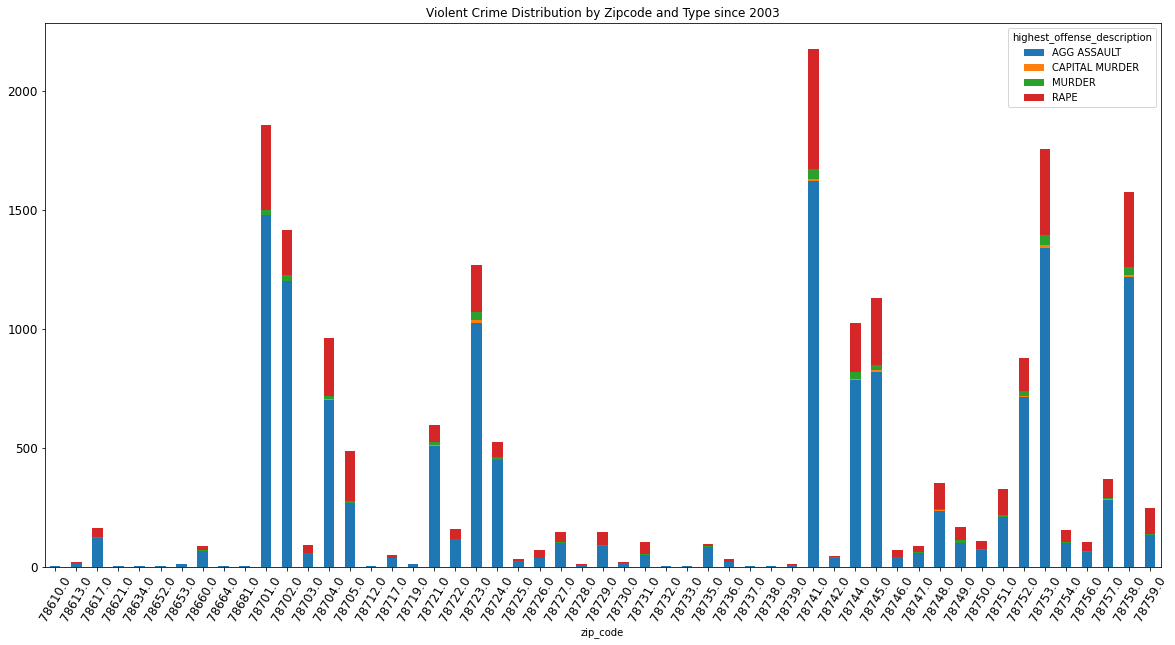

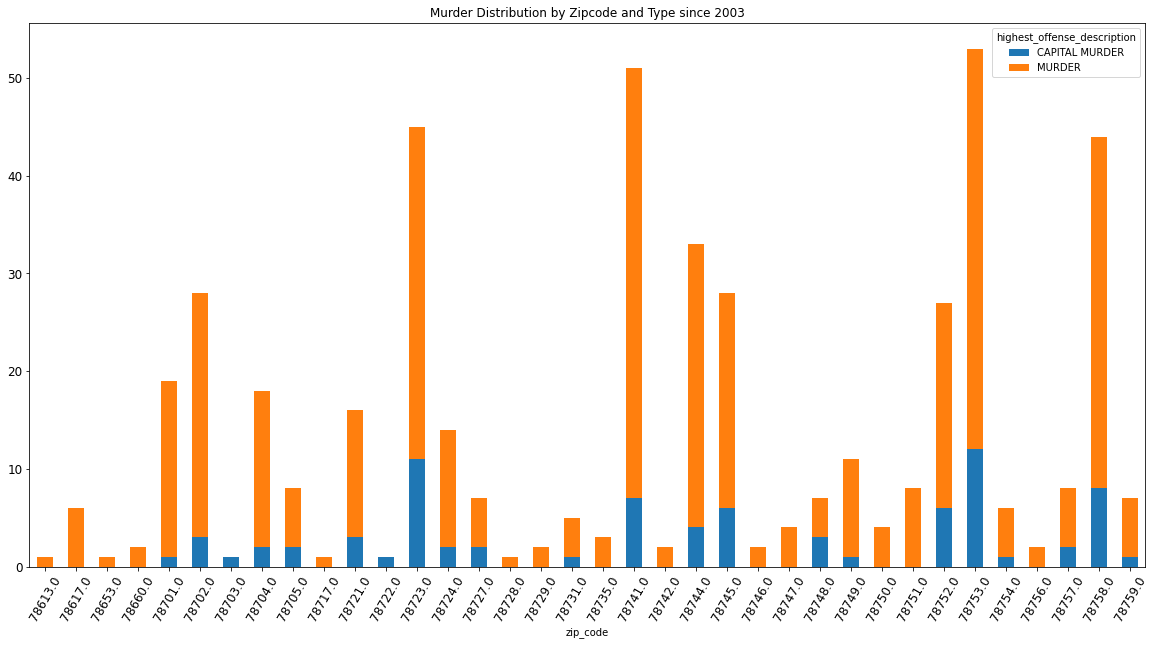

In [13]:
# Creating an overall and separate dataframes for violent crime

df_viol = df.query(
    'highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == "MURDER"]
df_mur_cap = df[df.highest_offense_description == "CAPITAL MURDER"]
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_rape = df[df.highest_offense_description == "RAPE"]

# Visualizing violent crimes per year

viol_per_year = df_viol["year"].value_counts().sort_index()
viol_per_year.plot.bar(
    rot=60, title="Annual Violent Crime Rates (2003-Present)", fontsize=12
)
plt.show()

# Visualizing murders per year

viol_mur_per_year = df_viol_mur.year.value_counts().sort_index()
viol_mur_per_year.plot.bar(
    rot=60, title="Annual Murder Rates (2003-Present)", fontsize=12
)
plt.show()

# Violent Crime by Zipcode

display(df_viol.zip_code.value_counts(normalize=True).head(25))
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top Zipcodes for Violent Crime", fontsize=12, rot=60
)
plt.show()

# Murder by Zipcode

display(df_viol_mur.zip_code.value_counts(normalize=True).head(25))
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    fontsize=12, title="Top Zipcodes for Murder", rot=60
)
plt.show()

mur_by_month = df_viol_mur["month"].value_counts().sort_index()
mur_by_hour = df_viol_mur["hour"].value_counts().sort_index()

# Visualizing monthly & hourly murder rate with Seaborn

v = sns.barplot(x=mur_by_month.index, y=mur_by_month.values)
v.set_xticklabels(v.get_xticklabels(), rotation=60)
v.set(
    xlabel="Month",
    ylabel="Crimes Reported",
    title="Monthly Murder Rates (2003-Present)",
)
plt.show()

f = sns.barplot(x=mur_by_hour.index, y=mur_by_hour.values)
f.set_xticklabels(f.get_xticklabels(), rotation=60)
f.set(
    xlabel="Hour", 
    ylabel="Crimes Reported", 
    title="Hourly Murder Rates (2003-Present)"
)
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(
    figsize=figsize,
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    fontsize=12,
    stacked=True,
    rot=60,
)
plt.show()

viol_mur_freq = pd.crosstab(
    df_viol_mur.zip_code, df_viol_mur.highest_offense_description
)

viol_mur_freq.plot.bar(
    figsize=figsize,
    title="Murder Distribution by Zipcode and Type since 2003",
    fontsize=12,
    stacked=True,
    rot=60,
)
plt.show()

According to the data , 2010 and 2016 had the most number of murders . Alarmingly, as of 10/19/2020, murders already totaled 34--the same amount for 2016 and 2010!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

Overall, family violence is seeing an upward trend as a crime factor. Violent crime saw an alarming upward trend of the family violence factor, as well. Rapes, for example, involved the family violence factor a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [14]:
# As a heatmap

mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=11)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="aus_mur_heatmap.html")

k

In [15]:
# Pinpointing individual addresses

mur_coords_add = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

m = folium.Map([30.2672, -97.7431], tiles="OpenStreetMap", zoom_level=12)

for (index, row) in mur_coords_add.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    name = row["address"]
    folium.Marker([lat, lon], popup=name).add_to(m)
m.save(outfile="aus_mur_map.html")

m

#### Are there any addresses where murder occurs frequently?

In [16]:
df_viol_mur.address.value_counts().head(31)

6407 SPRINGDALE RD           3
6409 SPRINGDALE RD           3
4700 E RIVERSIDE DR          3
8610 N LAMAR BLVD            3
8800 N IH 35 SVRD SB         3
1050 SPRINGDALE RD           2
1711 RUTLAND DR              2
8225 SAM RAYBURN DR          2
6118 FAIRWAY ST              2
601 E 15TH ST                2
2400 WICKERSHAM LN           2
7000 DECKER LN               2
10503 N LAMAR BLVD           2
10610 MORADO CIR             2
833 FAIRFIELD DR             2
9601 MIDDLE FISKVILLE RD     2
9200 NORTH PLZ               2
815 W SLAUGHTER LN           2
2713 S CONGRESS AVE          2
6600 ED BLUESTEIN BLVD SB    2
8912 N LAMAR BLVD            2
2101 ELMONT DR               2
201 W 5TH ST                 2
2915 S IH 35 SVRD NB         2
9220 N IH 35 SVRD SB         2
744 W WILLIAM CANNON DR      2
1137 GUNTER ST               2
9010 GALEWOOD DR             2
2501 ANKEN DR                2
2508 E RIVERSIDE DR          2
605 MASTERSON PASS           2
Name: address, dtype: int64

## V. Prediction Modeling 

### Time Series Modeling of the overall dataframe with Facebook Prophet 

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


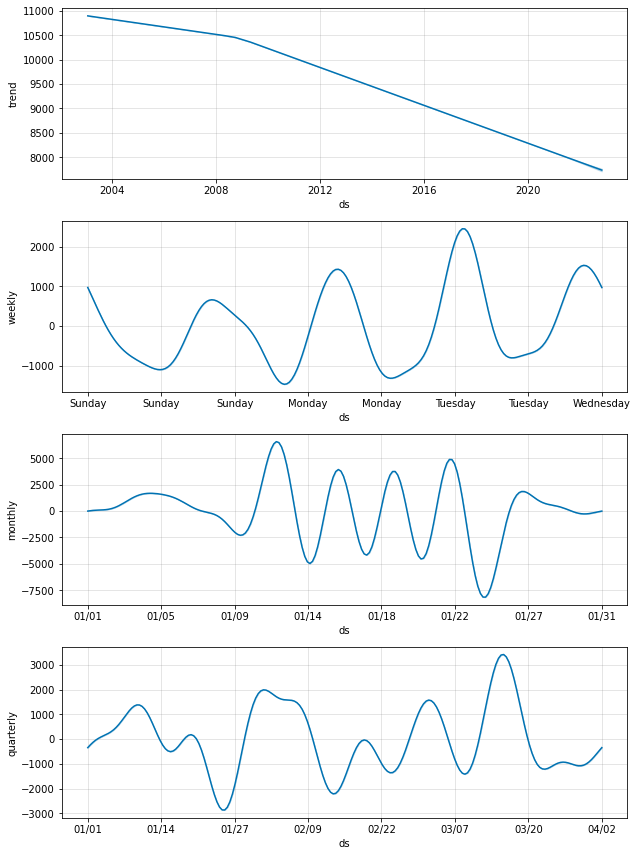

In [22]:
df_fbprophet = df

df_m_1 = df_fbprophet.resample("M").size().reset_index()
df_m_1.columns = ["date", "monthly_crime_count"]
df_m_final_1 = df_m_1.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_1 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_1.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_1.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_1.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_1.fit(df_m_final_1)

future_1 = m_1.make_future_dataframe(periods=24, freq="M")
pred_1 = m_1.predict(future_1)
fig2_1 = m_1.plot_components(pred_1)
fig2_2 = plot_plotly(m_1, pred_1)
fig2_2

### ...now the murder dataframe 

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


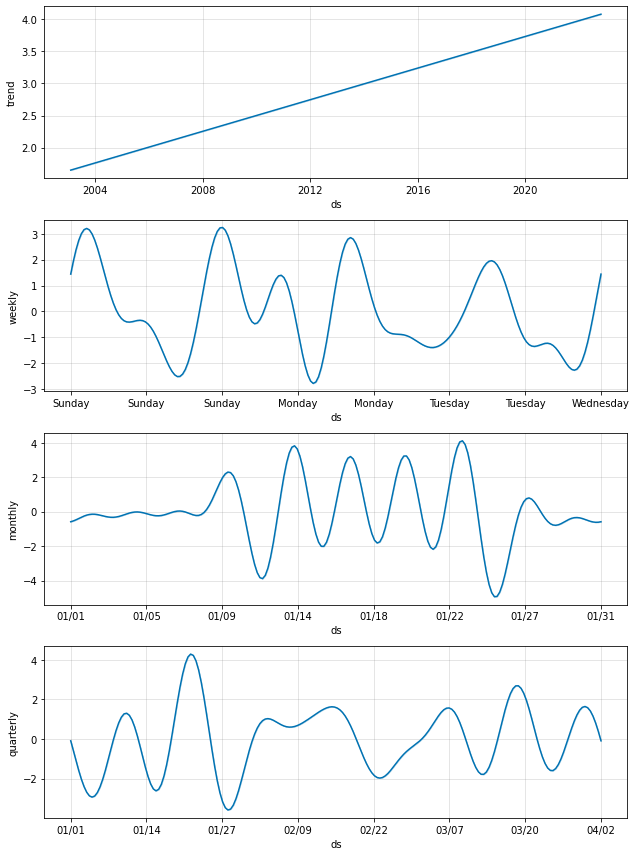

In [21]:
df_viol_mur_fbprophet = df_viol_mur

df_m = df_viol_mur_fbprophet.resample("M").size().reset_index()
df_m.columns = ["date", "monthly_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m = Prophet(interval_width=0.95, yearly_seasonality=False)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=24, freq="M")
pred = m.predict(future)
fig2_1 = m.plot_components(pred)
fig2_3 = plot_plotly(m, pred)
fig2_3

### ...now examining different zip codes

#### 78753

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


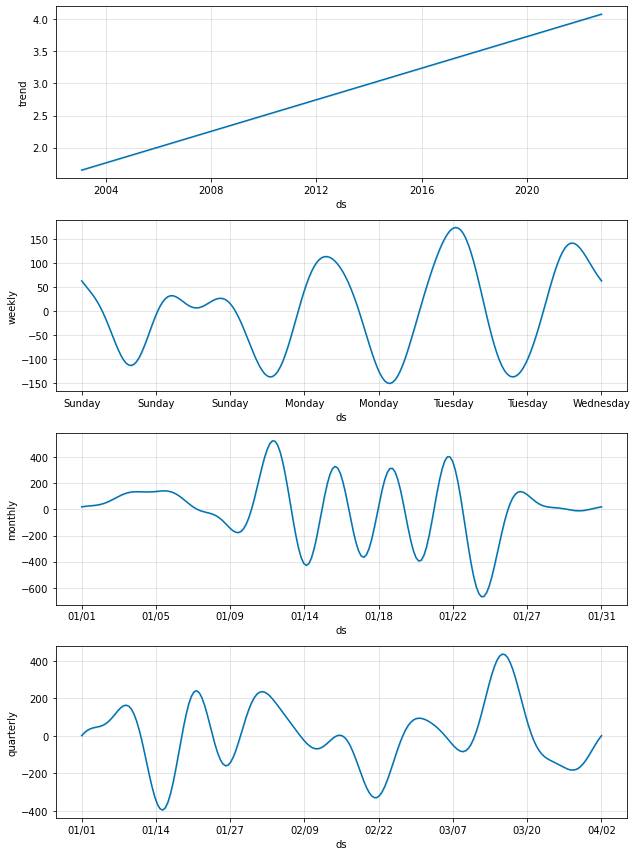

In [19]:
df_fbprophet_53 = df_53

df_m_53 = df_fbprophet_53.resample("M").size().reset_index()
df_m_53.columns = ["date", "monthly_crime_count"]
df_m_final_53 = df_m_53.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_53 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_53.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_53.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_53.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_53.fit(df_m_final_53)

future_53 = m_53.make_future_dataframe(periods=24, freq="M")
pred_53 = m_53.predict(future)
fig2_53 = m_53.plot_components(pred)
fig2_53_1 = plot_plotly(m_53, pred_53)
fig2_53_1

#### 78745

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


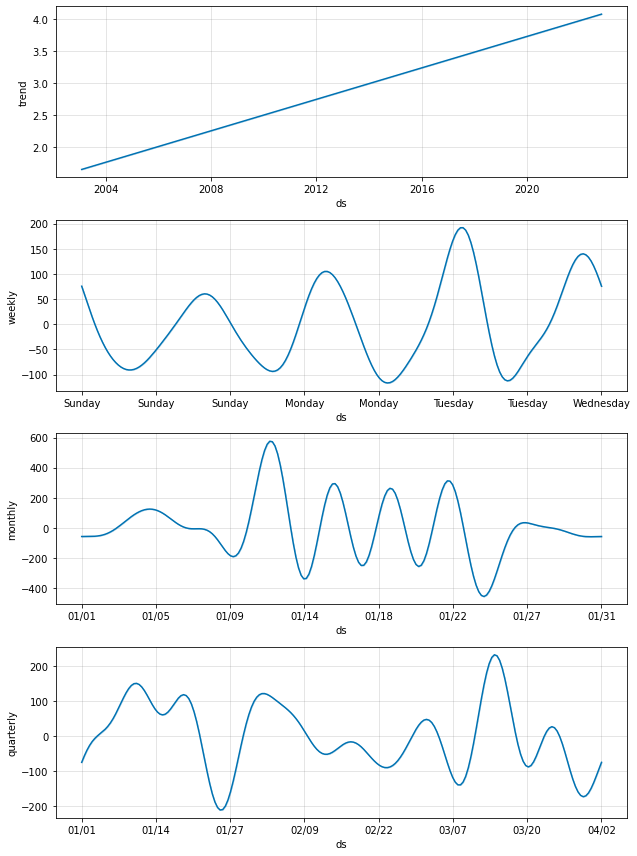

In [20]:
df_fbprophet_45 = df_45

df_m_45 = df_fbprophet_45.resample("M").size().reset_index()
df_m_45.columns = ["date", "monthly_crime_count"]
df_m_final_45 = df_m_45.rename(columns={"date": "ds", "monthly_crime_count": "y"})

(df_m_final_45.head(), df_m_final_45.tail())

m_45 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_45.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_45.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_45.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_45.fit(df_m_final_45)

future_45 = m_45.make_future_dataframe(periods=24, freq="M")
pred_45 = m_45.predict(future)
fig2_45 = m_45.plot_components(pred)
fig2_45_1 = plot_plotly(m_45, pred_45)
fig2_45_1